<a href="https://colab.research.google.com/github/Jaimemorillo/election-prediction-madrid/blob/main/read_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install pyvis

In [ ]:
pip install python-igraph

     |████████████████████████████████| 3.2MB 6.4MB/s 


In [ ]:
%load_ext rpy2.ipython

# Leemos los datos

In [ ]:
%%R
load("/content/gdrive/MyDrive/Tweets_elecciones/resultados_TFG_1.RData")
names(datos)
keep = c("user_id","name","status_id","screen_name",
         "created_at","text","favorite_count","retweet_count","reply_count","quote_count",
         "hashtags","mentions_user_id","mentions_screen_name",
         "reply_to_status_id","reply_to_user_id","reply_to_screen_name",
         "is_quote","is_retweet","quoted_status_id","quoted_text","quoted_favorite_count",
         "quoted_retweet_count","quoted_user_id","quoted_screen_name","retweet_status_id","retweet_user_id",
         "retweet_screen_name","retweet_statuses_count","retweet_followers_count","retweet_friends_count",
         "country","location","listed_count","statuses_count",
         "followers_count","friends_count","favourites_count","description","account_created_at")
datos = datos[,keep]
datos = as.data.frame(datos)
datos$mentions_user_id=vapply(datos$mentions_user_id, paste, collapse = ",", character(1L))
datos$mentions_screen_name=vapply(datos$mentions_screen_name, paste, collapse = ",", character(1L))
datos$hashtags=vapply(datos$hashtags, paste, collapse = ",", character(1L))

write.csv(datos, file="/content/resultados_TFG_1.csv", row.names = FALSE)

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from IPython.core.display import display, HTML
from pyvis.network import Network
from sklearn.preprocessing import MinMaxScaler
import igraph as ig

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

In [ ]:
df = pd.read_csv('/content/resultados_TFG_1.csv')

In [ ]:
def string_as_array(x):
  if x is not np.nan:
    return str(x).split(",")
  else:
    return np.nan

In [ ]:
df.mentions_user_id = df.mentions_user_id.apply(lambda x: string_as_array(x))
df.mentions_screen_name = df.mentions_screen_name.apply(lambda x: string_as_array(x))
df.hashtags = df.hashtags.apply(lambda x: string_as_array(x))

In [ ]:
df.head(10)

,user_id,name,status_id,screen_name,created_at,text,favorite_count,retweet_count,reply_count,quote_count,hashtags,mentions_user_id,mentions_screen_name,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,quoted_status_id,quoted_text,quoted_favorite_count,quoted_retweet_count,quoted_user_id,quoted_screen_name,retweet_status_id,retweet_user_id,retweet_screen_name,retweet_statuses_count,retweet_followers_count,retweet_friends_count,country,location,listed_count,statuses_count,followers_count,friends_count,favourites_count,description,account_created_at
0,1314271330745937924,El Guerrero del Antifaz 🇪🇸🏴󠁧󠁢󠁥󠁮󠁧󠁿🇵🇪✝️,1385208548729229317,antifazporspain,2021-04-22 12:27:08,Elecciones de la Com. Madrid: la derecha PP y ...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"London, England",4,11059,5318,5491,24543,Nadie debe conocer su sentido mientras no haya...,2020-10-08 18:28:18
1,1174971439478239238,Juan Ángel,1385208548146262017,JuanAngelArMor,2021-04-22 12:27:08,El CIS pronostica un vuelco electoral con la v...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12601,268,953,61975,"No sé nada, pero aprendí a pensar con lucidez ...",2019-09-20 09:01:40
2,1174971439478239238,Juan Ángel,1385204758001115137,JuanAngelArMor,2021-04-22 12:12:04,La izquierda pierde porque no vota. Porque se ...,0,194,NaN,NaN,NaN,[312963709],[maxpradera],NaN,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.385027e+18,3.129637e+08,maxpradera,57532.0,136546.0,1960.0,NaN,NaN,0,12601,268,953,61975,"No sé nada, pero aprendí a pensar con lucidez ...",2019-09-20 09:01:40
3,862102147,Гомо AragornEnsiZ🎗️,1385208546988593157,s0msirem,2021-04-22 12:27:08,@CosmonautGuy @MarcoMangut @VanderMonguer @Alb...,0,0,NaN,NaN,NaN,"[1878906385, 229154067, 1857019986, 91560739]","[CosmonautGuy, MarcoMangut, VanderMonguer, Alb...",1.384986e+18,1.878906e+09,CosmonautGuy,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tabernia de Rivendel 🍻,27,115914,927,935,9777,"Русский arент, Catalufo, Charnego, Aldeano, Na...",2012-10-04 21:53:56
4,893110171,Carles Casamayor,1385208539208114181,CarlesCasamayor,2021-04-22 12:27:06,@CarlesCasamayor @El_Plural De lo que no se ha...,0,1,NaN,NaN,NaN,"[484693767, 893110171, 158313996]","[JosMHernndezV, CarlesCasamayor, El_Plural]",NaN,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.385097e+18,4.846938e+08,JosMHernndezV,25139.0,613.0,802.0,NaN,Terrassa (Barcelona - Spain),10,23757,2105,1368,41709,"Progressista. Voluntari Creu Roja, fotografia,...",2012-10-20 12:02:41
5,940699411168092166,Andrés Agustin Duran,1385208536729329665,AndresAgustinD2,2021-04-22 12:27:05,"Gabilondo: ""Querido Pablo, espero tu apoyo""\n\...",0,6,NaN,NaN,NaN,[17676713],[publico_es],NaN,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.385207e+18,1.767671e+07,publico_es,457267.0,1071859.0,1506.0,NaN,NaN,2,197155,3657,5005,226130,NaN,2017-12-12 21:46:31
6,940699411168092166,Andrés Agustin Duran,1385190099625947137,AndresAgustinD2,2021-04-22 11:13:49,"PSOE, Podemos, ERC y Bildu salvan a Marlaska d...",0,71,NaN,NaN,NaN,[1120274781289558017],[veintimillapier],NaN,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.385189e+18,1.120275e+18,veintimillapier,21980.0,14588.0,15566.0,NaN,NaN,2,197155,3657,5005,226130,NaN,2017-12-12 21:46:31
7,940699411168092166,Andrés Agustin Duran,1385170528185487362,AndresAgustinD2,2021-04-22 09:56:03,"🔴 #ÚLTIMAHORA El CIS de Tezanos baja al PP 2,5...",0,8,NaN,NaN,[ÚLTIMAHORA],[19923515],[abc_es],NaN,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.385167e+18,1.992352e+07,abc_es,481091.0,2115573.0,14830.0,NaN,NaN,2,197155,3657,5005,226130,NaN,2017-12-12 21:46:31
8,940699411168092166,Andrés Agustin Duran,1385192419277352960,AndresAgustinD2,2021-04-22 11:23:03,Tezanos trata de reanimar a la izquierda con u...,0,5,NaN,NaN,NaN,[826854837304360960],[Ricardo13625223],NaN,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.385190e+18,8.268548e+17,Ri

In [ ]:
df.retweet_screen_name.value_counts()

PSOE              5866
Tonicanto1        3622
PODEMOS           3477
RubenSanchezTW    2486
JulianMaciasT     2014
                  ... 
Juan37151422         1
roberiban            1
AliRivers            1
ChancaCarlos         1
AnaMaseda3           1
Name: retweet_screen_name, Length: 3319, dtype: int64

In [ ]:
df[df['retweet_screen_name']=='PSOE'].screen_name.value_counts()

psoebetxi          46
DRZRZ              42
soniapillado70     42
CeutaPlataforma    42
WillyLozano        42
                   ..
pilar51             1
olavid25            1
PDiazAlejo          1
LimondeHormigon     1
aranjua             1
Name: screen_name, Length: 1579, dtype: int64

In [ ]:
df[df['retweet_screen_name']=='Tonicanto1'].screen_name.value_counts()

capadociados       2
Pilichinchina      2
LoliSernaElx       1
ser_maz            1
piky_Yeeh          1
                  ..
Galder43740803     1
Josebucete         1
AllMight2021       1
lachicadeayer64    1
MonicaLosc         1
Name: screen_name, Length: 3620, dtype: int64

# Creamos los nodos y las aristas

Nodos = usuarios de twitter.

A->B si B da retweet a A

Asignamos pesos a las aristas en función del número de RTs

In [ ]:
# Calculamos las aristas y los nodos
df_temp = df[['screen_name','retweet_screen_name']]
df_temp = df_temp[df_temp['screen_name']!=df_temp['retweet_screen_name']]
df_edge_list = df_temp.copy()
df_edge_list = df_edge_list.groupby(['screen_name', 'retweet_screen_name'], as_index=False).size().rename(columns={'size': 'weight'})
nodes_no_conection = df_temp[pd.isnull(df_temp['retweet_screen_name'])] # ¿Qué hacemos con los tweets aislados?
df_edge_list['width'] = df_edge_list['weight']

#df_edge_list = df_edge_list.sample(2000, random_state=9)
#df_edge_list = df_edge_list.head(20000)

nodes_size = df_edge_list.groupby('retweet_screen_name', as_index=False).size()
nodes_size['size'] = MinMaxScaler(feature_range=(5,50)).fit_transform(nodes_size['size'].values.reshape(-1,1))

#df_edge_list = df_edge_list.join(nodes.set_index('retweet_screen_name'), on='retweet_screen_name')
#df_edge_list = df_edge_list.sort_values('size', ascending=False)

In [ ]:
df_edge_list

,screen_name,retweet_screen_name,weight,width
0,000333dani,AmoedoCom,1,1
1,000333dani,Emma1492is,1,1
2,000333dani,JulianMaciasT,3,3
3,000333dani,PODEMOS,1,1
4,000333dani,rosamariaartal,1,1
...,...,...,...,...
63169,zzsgg,OrbitaEduardo,1,1
63170,zzsgg,Tonicanto1,1,1
63171,zzsgg,janogarcia_,1,1
63172,zzzz46324949,RubenSanchezTW,1,1


In [ ]:
#Calculamos atributos de los nodos
df_temp1 = df[['screen_name','statuses_count','followers_count','friends_count',
               'created_at','favourites_count','account_created_at']]
df_temp2 = df[['retweet_screen_name','retweet_statuses_count',
               'retweet_followers_count','retweet_friends_count','created_at']]
df_temp2['favourites_count'] = np.nan
df_temp2['account_created_at'] = np.nan
df_temp2.columns = df_temp1.columns
df_temp = df_temp2.append(df_temp1).reset_index(drop=True).dropna(subset=['screen_name'])
nodes = df_temp.drop_duplicates(subset=['screen_name'], keep='last').reset_index(drop=True)
nodes['days_old'] = (pd.to_datetime(nodes['created_at']) - pd.to_datetime(nodes['account_created_at'])).dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
G = nx.from_pandas_edgelist(df_edge_list, 
                            source='retweet_screen_name',
                            target='screen_name',
                            edge_attr=['weight','width'],
                            create_using=nx.DiGraph())

nx.set_node_attributes(G, pd.Series(nodes_size.set_index('retweet_screen_name')['size']).to_dict(), 'size')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['statuses_count']).to_dict(), 'statuses_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['followers_count']).to_dict(), 'followers_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['friends_count']).to_dict(), 'friends_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['favourites_count']).to_dict(), 'favourites_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['days_old']).to_dict(), 'days_old')

In [ ]:
g = ig.Graph.from_networkx(G)

# Pintamos la red

Al pintar la red con una muestra de unos 2000 nodos del primer día de campaña se ve que la izquierda y la derecha se encuentra bastante bien divididas.

Toni Canto claramente está emparejado con vox cuando él pertenece a Cs. O al PP, pero lo que hace claramente lo pone en otra "Comunidad". Esto se verá mucho más claro cuando hagamos comunidades

In [ ]:
net = Network(height='720px', width='1280px', notebook=True, directed=True)
net.from_nx(G)

net.show('red.html')
display(HTML('red.html'))

# Motifs

He calculado la frecuencia de los motifs de tamaño 3 y he visto que las relaciones que se dan son siempre de dominancia.

Las estructuras están centralizadas entorno a los nodos que originan la información (creadores de contenido viral), que casi siempre son los propios partidos o sus políticos.

Desde el punto de vista estructural, tenemos cosas interesantes y es que las tres subestructuras que se dan son

CASO 1. De trasmiision directa A manda a B y C caso más habitual. Viralización.

CASO 2. a y b mandan a C. Esta estructura es curiosa y es gente que escucha de varios lideres.

CASO 3. A --b --C menos frecuente pero denota cierta intermediación de algunos tuiteros. La informacion no siembre se escucha directamente desde el emisor sino que recorre caminos de mayor longitud por lo que ciertos actores son relevantes en la intermediación.

No hay casi ciclos A con B, B con C y C con A (QUE SERIA LO LÓGICO EN UN DEBATE DONDE FLUYE LA INFORMACIÓN)). 

Con los motifs de tamaño 4 vemos que los más frecuentes son los derivados de las estructuras de tamaño 3 vistas antes, lo más importante aquí es ver que no encontramos cadenas de 4 nodos A->B->C->D.

In [ ]:
def get_motifs(g, size=3):
  motifs = g.motifs_randesu(size=size, cut_prob=None)
  for idx,i in enumerate(motifs):
    if i>=5000 and not np.isnan(i):
      print('freq: ' + str(i))
      print(ig.Graph.Isoclass(n=size, cls=idx, directed=True))
      print('--------------------------------------------')
  return None

In [ ]:
get_motifs(g,3)

freq: 113023
IGRAPH D--- 3 2 --
+ edges:
2->0 1->0
--------------------------------------------
freq: 64940
IGRAPH D--- 3 2 --
+ edges:
0->1 2->0
--------------------------------------------
freq: 24142584
IGRAPH D--- 3 2 --
+ edges:
2->1 2->0
--------------------------------------------
freq: 10453
IGRAPH D--- 3 3 --
+ edges:
2->1 2->0 1->0
--------------------------------------------
freq: 15378
IGRAPH D--- 3 3 --
+ edges:
0->2 0->1 1->0
--------------------------------------------


In [ ]:
get_motifs(g,4)

freq: 123952
IGRAPH D--- 4 3 --
+ edges:
3->0 2->0 1->0
--------------------------------------------
freq: 15789
IGRAPH D--- 4 3 --
+ edges:
0->1 3->0 2->0
--------------------------------------------
freq: 21928
IGRAPH D--- 4 3 --
+ edges:
2->1 3->0 1->0
--------------------------------------------
freq: 10009449
IGRAPH D--- 4 3 --
+ edges:
2->1 3->0 2->0
--------------------------------------------
freq: 9537
IGRAPH D--- 4 4 --
+ edges:
2->1 3->0 2->0 1->0
--------------------------------------------
freq: 5622
IGRAPH D--- 4 4 --
+ edges:
2->1 0->1 3->0 2->0
--------------------------------------------
freq: 190837
IGRAPH D--- 4 4 --
+ edges:
3->1 2->1 3->0 2->0
--------------------------------------------
freq: 1535
IGRAPH D--- 4 5 --
+ edges:
3->1 2->1 3->0 2->0 1->0
--------------------------------------------
freq: 401816
IGRAPH D--- 4 3 --
+ edges:
0->2 0->1 3->0
--------------------------------------------
freq: 1737
IGRAPH D--- 4 4 --
+ edges:
0->2 0->1 3->0 1->0
-------------

# Clasificación de nodos

## Por grado

In [ ]:
vertex_df = g.get_vertex_dataframe().drop(columns=['size'])

In [ ]:
vertex_df['degree'] = g.degree()
vertex_df['out_degree'] = g.outdegree()
vertex_df['in_degree'] = g.indegree()
vertex_df['ratio_degree'] = (vertex_df['out_degree']) / (vertex_df['in_degree'])

In [ ]:
def get_degree_class(x):
  if 0<=x<=0.5:
    return 'Listener'
  elif 0.5<x<2:
    return 'Transmitter/Dialoguer'
  elif x>=2:
    return 'Emitter'
  else:
    return None

vertex_df['degree_class'] = vertex_df['ratio_degree'].apply(lambda x: get_degree_class(x))

**ratio_degree** = degree_out / degree_in

- Listener (oyente) --- 0 <= ratio <= 0.5
- Transmitter/Dialoguer (dialogador) --- 0.5 < ratio < 2 
- Emitter (emisor) --- ratio >= 2 

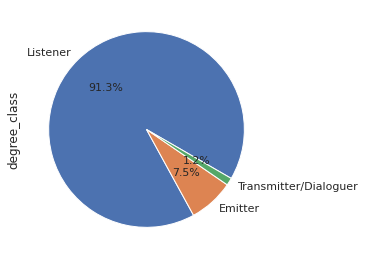

In [ ]:
vertex_df['degree_class'].value_counts(normalize=True).plot(kind='pie', fontsize=11,
                                                           autopct='%1.1f%%', startangle=-30, figsize=(4.5,4.5))

## Por tipo de usuario

https://azsocialmediawiz.com/5-types-twitter-users/

**ratio_user** = followers_count / friends_count

The Newsmaker --- ratio_user >= 2

Information Gatherer --- 0 <= ratio_user <= 0.5

Relationship Builder --- 0.5 < ratio_user < 2

Newbie --- 0.5 < ratio_user < 2 y followers_count < 100

Spammer/Fake --- 

- Cuenta con un ratio_user < 0.7
- Menos de 500 followers
- Ratio de contenido(tweets + favs) /followers alto
- Ratio de contenido(tweets + favs) /dias alto



In [ ]:
vertex_df['ratio_user'] = (vertex_df['followers_count'] / (vertex_df['friends_count']+1))
vertex_df['ratio_tweets_followers'] = (vertex_df['statuses_count']+vertex_df['favourites_count'])/ (vertex_df['followers_count']+1)
vertex_df['ratio_tweets_antiguedad'] =(vertex_df['statuses_count']+vertex_df['favourites_count']) / (vertex_df['days_old']+1)

vertex_df['ratio_spam'] = 0.3*vertex_df['ratio_tweets_followers'] + 0.7*vertex_df['ratio_tweets_antiguedad']

In [ ]:
vertex_df[['followers_count','friends_count','ratio_user']].describe().round(2)

,followers_count,friends_count,ratio_user
count,33040.00,33040.00,33040.00
mean,4132.22,1349.19,12.50
std,68206.57,2694.37,591.01
min,0.00,0.00,0.00
25%,121.00,243.00,0.37
50%,381.00,610.00,0.66
75%,1285.00,1501.00,1.03
max,8037826.00,96502.00,63508.00


In [ ]:
ratio_spam_cut = vertex_df[(vertex_df['ratio_user']<0.7)&(vertex_df['followers_count']<500)]['ratio_spam'].quantile(0.85)

def get_user_class(x):
  if x['ratio_user']<0.7 and x['followers_count']<500 and x['ratio_spam']>=ratio_spam_cut:
    return 'Spammer/Fake'
  elif x['ratio_user']<=0.5:
    return 'Information Gatherer'
  elif 0.5<x['ratio_user']<2 and x['followers_count']<100:
    return 'Newbie'
  elif 0.5<x['ratio_user']<2:
    return 'Relationship Builder'
  elif x['ratio_user']>=2:
    return 'The Newsmaker'
  else:
    return 'Spammer/Fake'

In [ ]:
vertex_df['user_class'] = vertex_df.apply(lambda x: get_user_class(x), axis=1)

In [ ]:
vertex_df.user_class.value_counts()

Relationship Builder    15744
Information Gatherer    10597
The Newsmaker            3224
Spammer/Fake             2011
Newbie                   1464
Name: user_class, dtype: int64

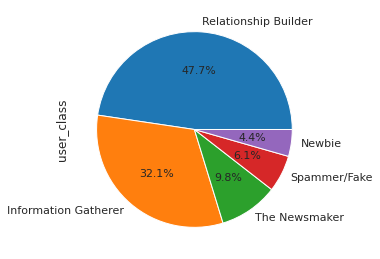

In [ ]:
color_dict = {'Relationship Builder':'tab:blue', 
              'Information Gatherer':'tab:orange',
              'The Newsmaker':'tab:green',
              'Spammer/Fake':'tab:red',
              'Newbie':'tab:purple'}

vertex_df.user_class.value_counts().plot(kind='pie', fontsize=11,
                                         autopct='%1.1f%%', startangle=0, figsize=(4.5,4.5),
                                         colors=[color_dict.get(x) for x in vertex_df.user_class.value_counts().keys()])

(0.0, 1.0, 0.0, 1.0)

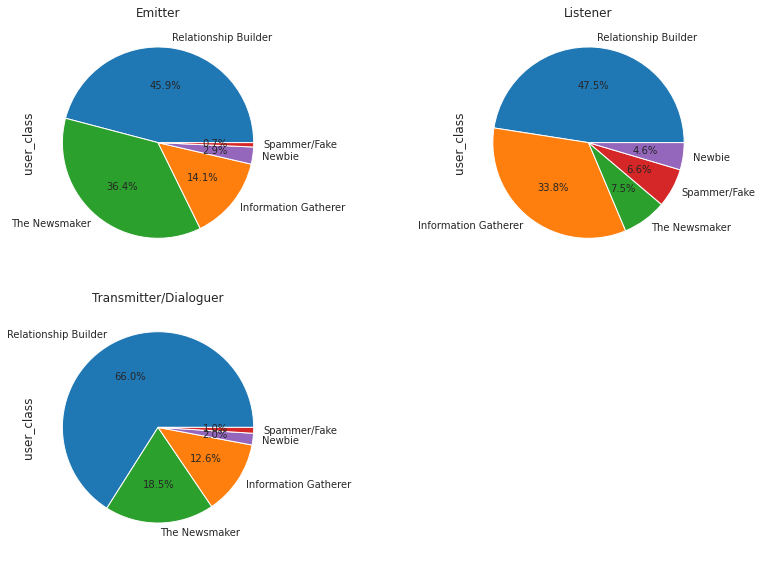

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
plt.subplots_adjust(wspace=0.8,hspace=0.1)

vertex_df[vertex_df['degree_class']=='Emitter'].user_class.value_counts().plot(kind='pie', fontsize=10,
                                                autopct='%1.1f%%', startangle=0, title='Emitter',
                                                ax=axes[0,0], 
                                                colors=[color_dict.get(x) for x in vertex_df[vertex_df['degree_class']=='Emitter'].user_class.value_counts().keys()])
vertex_df[vertex_df['degree_class']=='Listener'].user_class.value_counts().plot(kind='pie', fontsize=10,
                                                autopct='%1.1f%%', startangle=0, title='Listener',
                                                ax=axes[0,1],
                                                colors=[color_dict.get(x) for x in vertex_df[vertex_df['degree_class']=='Listener'].user_class.value_counts().keys()])
vertex_df[vertex_df['degree_class']=='Transmitter/Dialoguer'].user_class.value_counts().plot(kind='pie', fontsize=10,
                                                autopct='%1.1f%%', startangle=0, title='Transmitter/Dialoguer',
                                                ax=axes[1,0],
                                                colors=[color_dict.get(x) for x in vertex_df[vertex_df['degree_class']=='Transmitter/Dialoguer'].user_class.value_counts().keys()])
axes[1,1].axis('off')

# Rankings
https://es.wikipedia.org/wiki/Centralidad

## Seguidores

In [ ]:
vertex_df.sort_values(by='followers_count',ascending=False)[['_nx_name','followers_count','degree_class','user_class']].head(10)

,_nx_name,followers_count,degree_class,user_class
vertex ID,,,,
199,el_pais,8037826.0,Emitter,The Newsmaker
337,elmundoes,3935007.0,Emitter,The Newsmaker
26489,Reforma,3307874.0,Emitter,The Newsmaker
798,PabloIglesias,2649270.0,Emitter,The Newsmaker
2199,abc_es,2115599.0,Emitter,The Newsmaker
2111,A3Noticias,1984852.0,Emitter,The Newsmaker
10862,EFEnoticias,1909405.0,Emitter,The Newsmaker
8170,sanchezcastejon,1567759.0,Emitter,The Newsmaker
4,PODEMOS,1526489.0,Emitter,The Newsmaker


## Grado de salida

Los que llegan a máás gente

In [ ]:
vertex_df.sort_values(by='out_degree',ascending=False)[['_nx_name','followers_count','out_degree',
                                                        'in_degree','degree_class','user_class']].head(10)

,_nx_name,followers_count,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,
12,Tonicanto1,390662.0,3619,0,Emitter,The Newsmaker
8,RubenSanchezTW,276951.0,2402,0,Emitter,The Newsmaker
4,PODEMOS,1526489.0,2322,2,Emitter,The Newsmaker
18,ElHuffPost,511029.0,1895,1,Emitter,The Newsmaker
23,PSOE,822624.0,1579,4,Emitter,The Newsmaker
63,vox_es,438802.0,1426,2,Emitter,The Newsmaker
3,JulianMaciasT,59564.0,1338,2,Emitter,The Newsmaker
30,janogarcia_,190965.0,1110,0,Emitter,The Newsmaker
16,luisgonzaloseg,60811.0,940,0,Emitter,The Newsmaker


## Grado de entrada

Los que reciben más información

In [ ]:
vertex_df.sort_values(by='in_degree',ascending=False)[['_nx_name','followers_count','out_degree',
                                                        'in_degree','degree_class','user_class']].head(10)

,_nx_name,followers_count,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,
25662,jpmg71,731.0,0,46,Listener,Relationship Builder
26634,locuspolitikus,12162.0,0,45,Listener,Relationship Builder
19664,aneshali,4892.0,0,41,Listener,Relationship Builder
27702,troyana25,2833.0,1,41,Listener,The Newsmaker
1254,psoe_m,33007.0,87,40,Emitter,The Newsmaker
20516,bimbalalombarda,1079.0,1,39,Listener,Information Gatherer
29858,pilichus,1693.0,0,38,Listener,Relationship Builder
4099,Carmen56257613,463.0,0,37,Listener,Information Gatherer
2057,cleosagas1,8451.0,21,36,Transmitter/Dialoguer,Relationship Builder


## Capacidad de difusión RT
 
¿A cuánta gente han podido llegar con su RT?

In [ ]:
vertex_df['diffusion_capacity'] = vertex_df['in_degree'] * vertex_df['followers_count']
vertex_df.sort_values(by='diffusion_capacity',ascending=False)[['_nx_name','followers_count', 'diffusion_capacity',
                                                       'out_degree','in_degree','degree_class','user_class']].head(10)

,_nx_name,followers_count,diffusion_capacity,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,,
199,el_pais,8037826.0,8037826.0,317,1,Emitter,The Newsmaker
23,PSOE,822624.0,3290496.0,1579,4,Emitter,The Newsmaker
4,PODEMOS,1526489.0,3052978.0,2322,2,Emitter,The Newsmaker
261,CiudadanosCs,521014.0,2084056.0,509,4,Emitter,The Newsmaker
33,Santi_ABASCAL,576906.0,1730718.0,655,3,Emitter,The Newsmaker
2306,rtvenoticias,1462027.0,1462027.0,14,1,Emitter,The Newsmaker
386,europapress,1400175.0,1400175.0,115,1,Emitter,The Newsmaker
1254,psoe_m,33007.0,1320280.0,87,40,Emitter,The Newsmaker
2921,rtve,1204260.0,1204260.0,22,1,Emitter,The Newsmaker


## Centralidad de cercanía

In [ ]:
vertex_df['closeness_centrality'] = g.closeness()

In [ ]:
vertex_df.sort_values(by='closeness_centrality',ascending=False)[['_nx_name','followers_count','closeness_centrality',
                                                                  'out_degree','in_degree','degree_class',
                                                                  'user_class']].head(10)

,_nx_name,followers_count,closeness_centrality,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,,
16520,SanjuanRodolfo,45.0,1.0,0,1,Listener,Newbie
16049,alvaro_ct,804.0,1.0,1,0,Emitter,Information Gatherer
15795,ReedRichards87,181.0,1.0,0,1,Listener,Information Gatherer
15824,WinSmith1984_,6988.0,1.0,3,0,Emitter,Relationship Builder
15868,_luislopez92,130.0,1.0,3,0,Emitter,Information Gatherer
15911,Rosario62852968,61.0,1.0,1,0,Emitter,Information Gatherer
15912,RichardRB69,47.0,1.0,0,1,Listener,Newbie
15944,xavier_alcala,2217.0,1.0,2,0,Emitter,The Newsmaker
16050,Rodrigo_Ibeas_P,2381.0,1.0,0,1,Listener,Relationship Builder


## Centralidad de intermediación

In [ ]:
vertex_df['betweenness_centrality'] = g.betweenness(directed=True)

In [ ]:
vertex_df.sort_values(by='betweenness_centrality',ascending=False)[['_nx_name','followers_count','betweenness_centrality',
                                                                    'out_degree','in_degree','degree_class',
                                                                    'user_class']].head(10)

,_nx_name,followers_count,betweenness_centrality,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,,
4852,Dsagunt,2735.0,133572.300658,25,10,Emitter,Relationship Builder
0,AmoedoCom,20318.0,121842.384144,448,2,Emitter,Relationship Builder
4854,_seanma_mo_11TW,6971.0,116462.722619,10,4,Emitter,Relationship Builder
881,_meloncin69,5895.0,116000.738980,66,17,Emitter,Relationship Builder
233,HispaniaIb,2059.0,102215.652979,59,13,Emitter,Relationship Builder
36,budaoscar1,3674.0,84035.874657,367,5,Emitter,Relationship Builder
536,REALFANCLUBDVOX,5886.0,77831.957530,48,12,Emitter,Relationship Builder
1698,EParrilla7,2985.0,75623.320790,32,8,Emitter,Relationship Builder
355,mikihoyos,11779.0,73552.761919,81,11,Emitter,Relationship Builder


## Centralidad de autovector

https://en.wikipedia.org/wiki/Eigenvector_centrality

In [ ]:
vertex_df['eigenvector_centrality'] = g.eigenvector_centrality(directed=True)

In [ ]:
vertex_df.sort_values(by='eigenvector_centrality',ascending=False)[['_nx_name','followers_count','eigenvector_centrality',
                                                                    'out_degree','in_degree','degree_class',
                                                                    'user_class']].head(10)

,_nx_name,followers_count,eigenvector_centrality,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,,
32350,valkiria642,18290.0,1.000000,0,17,Listener,Relationship Builder
6362,elmuycastigado,14360.0,0.787232,5,11,Listener,Relationship Builder
233,HispaniaIb,2059.0,0.715090,59,13,Emitter,Relationship Builder
32071,tony73_,8491.0,0.704965,0,14,Listener,The Newsmaker
7717,Gimnastico84,7828.0,0.702637,0,10,Listener,Relationship Builder
3027,Barandaand,11469.0,0.683942,0,27,Listener,Relationship Builder
16593,SaulTrend,3805.0,0.606380,0,31,Listener,Relationship Builder
14365,lafuria1234,2433.0,0.559169,1,10,Listener,Relationship Builder
230,1979Nati,12747.0,0.547441,0,14,Listener,Relationship Builder


# Estadísticos

- **Vértices**: 33040
- **Aristas dirigidas**: 63174
- **Grado de salida medio**: 1.91 - **desviación típica**: 38.23 	(Heavy-tailed distribution)
- **Grado de entrada medio**: 1.91 - **desviación típica**: 2.43
- **Componente más largo**: 59 - 0.18% de los vértices
- **Diametro (lmax)**: 17 (https://mathworld.wolfram.com/GraphDiameter.html)
- **Distancia media \<l>**: 4.85 https://www.sciencedirect.com/topics/computer-science/geodesic-distance
- **Densidad**: 6e-5 https://es.wikipedia.org/wiki/Densidad_(teor%C3%ADa_de_grafos)
- **Coeficiente de agrupamiento (global)**: 3e-04 https://en.wikipedia.org/wiki/Clustering_coefficient

In [ ]:
print(g.vcount())
print(g.ecount())

33040
63174


In [ ]:
vertex_df[['degree','out_degree','in_degree']].describe().round(2)

,degree,out_degree,in_degree
count,33040.00,33040.00,33040.00
mean,3.82,1.91,1.91
std,38.29,38.23,2.43
min,1.00,0.00,0.00
25%,1.00,0.00,1.00
50%,1.00,0.00,1.00
75%,2.00,0.00,2.00
max,3619.00,3619.00,46.00


In [472]:
cl = g.clusters(mode='strong') # Calculates the (strong or weak) clusters (connected components) for a given graph.
lcc = cl.giant() #Returns the largest cluster
print(lcc.vcount())
print("{0:.2%}".format((lcc.vcount()/g.vcount())))
print(g.diameter())
print(g.average_path_length())
print(round(g.density(),5))
print(g.transitivity_undirected())
print(nx.transitivity(G)) #No esta en igraph, solo para no dirigidos

59
0.18%
17
4.854511474899213
6e-05
0.0014884896533988309
0.0002846514121697011


## Null model

### Erdos-Renyi model

p= \<k>/(n-1)

In [433]:
p = ig.mean(g.outdegree())/(g.vcount()-1)

In [434]:
round(p,5)

6e-05

In [467]:
er_g = ig.Graph().Erdos_Renyi(n=g.vcount(), p=p, directed=True)
E = er_g.get_edgelist()
er_G = nx.DiGraph(E)

In [436]:
vertex_er_df = er_g.get_vertex_dataframe()
vertex_er_df['degree'] = er_g.degree()
vertex_er_df['out_degree'] = er_g.outdegree()
vertex_er_df['in_degree'] = er_g.indegree()

In [437]:
vertex_er_df.describe().round(2)

,degree,out_degree,in_degree
count,33040.00,33040.00,33040.00
mean,3.84,1.92,1.92
std,1.95,1.38,1.38
min,0.00,0.00,0.00
25%,2.00,1.00,1.00
50%,4.00,2.00,2.00
75%,5.00,3.00,3.00
max,14.00,10.00,9.00


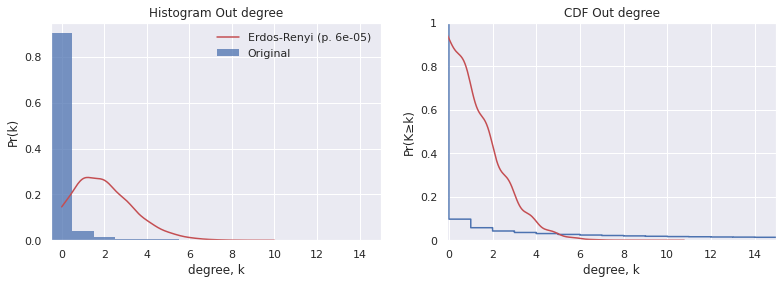

In [438]:
# Out degree
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)

sns.histplot(data=vertex_df, x='out_degree',stat='probability',discrete=True,label='Original',ax=ax1)
sns.kdeplot(data=vertex_er_df, x='out_degree', bw_adjust=3, color='r', label='Erdos-Renyi (p. 6e-05)',cut=0,ax=ax1)
ax1.set_xlim(-.5, 15)
ax1.set_ylabel('Pr(k)')
ax1.set_xlabel('degree, k')
ax1.legend()
ax1.set_title('Histogram Out degree')

sns.ecdfplot(data=vertex_df,x='out_degree',complementary=False,label='Original',ax=ax2)
sns.kdeplot(data=vertex_er_df,x='out_degree',color='r',cumulative=True,bw_adjust=1.5,label='Erdos-Renyi (p. 6e-05)',ax=ax2)
yticks=ax2.get_yticks()
ax2.invert_yaxis()
ax2.set_yticklabels([1,0.8,0.6,0.4,0.2,0])
ax2.set_xlim(-.1, 15)
ax2.set_ylabel('Pr(K≥k)')
ax2.set_xlabel('degree, k')
ax2.set_title('CDF Out degree')
plt.show()

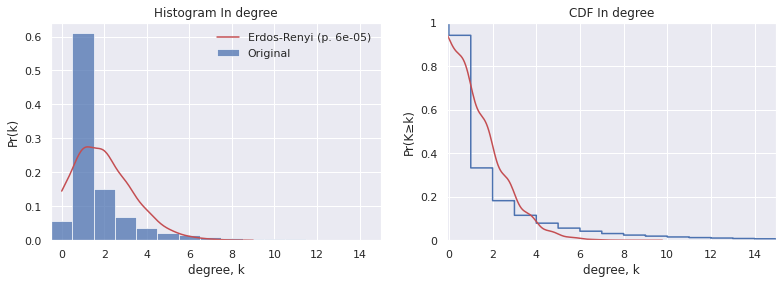

In [439]:
# In degree
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)

sns.histplot(data=vertex_df, x='in_degree',stat='probability',discrete=True,fill=True,label='Original',ax=ax1)
sns.kdeplot(data=vertex_er_df, x='in_degree', bw_adjust=3, color='r',cut=0,label='Erdos-Renyi (p. 6e-05)',ax=ax1)
ax1.set_xlim(-.5, 15)
ax1.set_ylabel('Pr(k)')
ax1.set_xlabel('degree, k')
ax1.legend()
ax1.set_title('Histogram In degree')

sns.ecdfplot(data=vertex_df,x='in_degree',complementary=False,label='Original',ax=ax2)
sns.kdeplot(data=vertex_er_df,x='in_degree',color='r',cumulative=True,bw_adjust=1.5,label='Erdos-Renyi (p. 6e-05)',ax=ax2)
yticks=ax2.get_yticks()
ax2.invert_yaxis()
ax2.set_yticklabels([1,0.8,0.6,0.4,0.2,0])
ax2.set_xlim(-.1, 15)
ax2.set_ylabel('Pr(K≥k)')
ax2.set_xlabel('degree, k')
ax2.set_title('CDF In degree')
plt.show()

In [473]:
cl = er_g.clusters(mode='strong') # Calculates the (strong or weak) clusters (connected components) for a given graph.
lcc = cl.giant() #Returns the largest cluster
print(lcc.vcount())
print("{0:.2%}".format((lcc.vcount()/g.vcount())))
print(er_g.diameter())
print(er_g.average_path_length())
print(round(er_g.density(),5))
print(er_g.transitivity_undirected())
print(nx.transitivity(er_G))

19709
59.65%
35
14.719659522654124
6e-05
7.411311308014098e-05
1.641793495214172e-05


Se ve claramente que el modelo es muy diferente a nuestra red, sobre todo en relación a los grados out de los vertices.

El modelo Erdos-Renyi situa mucha densidad entorno al grado medio y muy poca en los nodos con grados extremos.

Para los grados in de nuestros vertices, el modelo se comporta mejor, pero estima muy por debajo los nodos de grado 1.

Medidas:

- **Componente más largo**: (19709, 59.65%) vs (**59**, 0.18%)
- **Diametro (lmax)**: 35 vs **17**
- **Distancia media <l>**: 14.72 vs **4.85**
- **Densidad**: 6e-5 vs **6e-5**
- **Coeficiente de agrupamiento (global)**: 1.6e-05 vs **3e-04**

El componente más largo, el diametro y la distancia media ahora son mucho más grandes. Mientras que el coeficiente de agrupamiento es más pequeño.

Con esto llegamos a la conclusión que hay características estructurales de nuestra red que no están explicadas únicamente por la densidad de las aristas.
